<a href="https://colab.research.google.com/github/lawgorithm/timeseries/blob/main/ARIMA/SARIMA_and_Holt_Winters_Examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SARIMA and Holt-Winters Examples

In [1]:
!pip install pmdarima

In [2]:
# @title Imports
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import ndiffs
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm

In [3]:
# @title Load the Souvenir Sales data from GitHub
data_url = 'https://raw.githubusercontent.com/lawgorithm/timeseries/main/data/SouvenirSales.csv'
suv = pd.read_csv(data_url)
print(suv.head())

     Date    Sales
0  Jan-95  1664.81
1  Feb-95  2397.53
2  Mar-95  2840.71
3  Apr-95  3547.29
4  May-95  3752.96


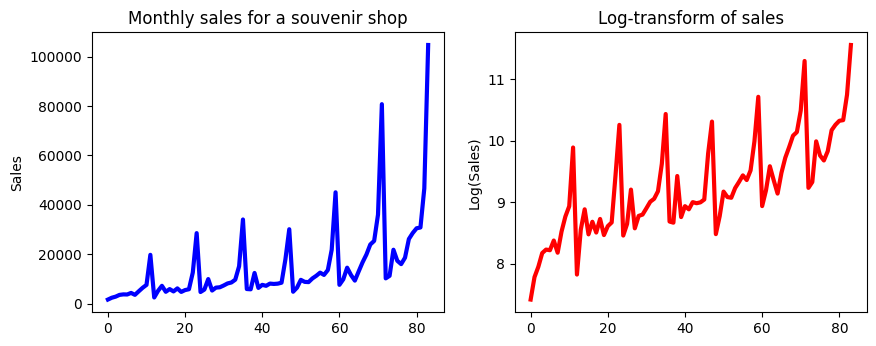

In [4]:
# First, we will plot the time series
plt.figure(figsize=(10, 8))  # Adjust figure size as needed

# This time series is clearly not stationary. There is an
# increasing trend and increasing variance over time and there
# appears to be some seasonality
plt.subplot(2, 2, 1)  # Create a subplot for the time series
plt.plot(suv['Sales'], color='blue', linewidth=3)
plt.title('Monthly sales for a souvenir shop')
plt.ylabel('Sales')

# We try a log transformation, which seems to handle
# the problem of increasing variance over time. However,
# a trend upwards still remains
plt.subplot(2, 2, 2)

plt.plot(np.log(suv['Sales']), color='red', linewidth=3)
plt.title('Log-transform of sales')
plt.ylabel('Log(Sales)')

plt.show()


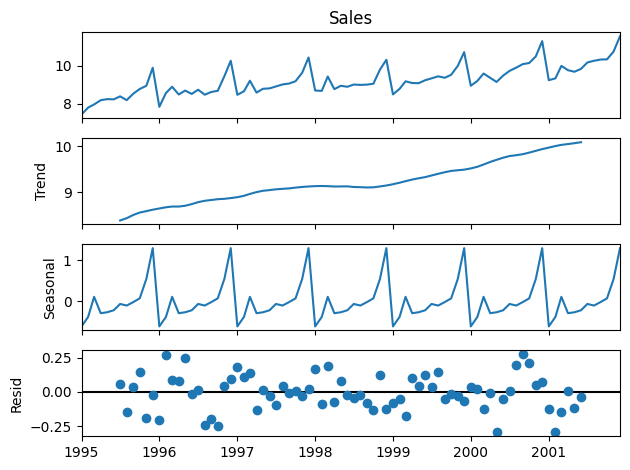

In [5]:
# The decompose function is a nice function that non-parametrically
# visually decomposes your time series into trend, seasonal and random
# components. See https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/decompose
# to understand the methodology, which is pretty simple

# Reformat the date column
suv['Date'] = pd.to_datetime(suv['Date'], format='%b-%y')

# Set 'Date' as index
suv.set_index('Date', inplace=True)

# Extract time series
data_ts = suv['Sales']

# Perform seasonal decomposition with specified period
decomposition = seasonal_decompose(np.log(data_ts), model='additive', period=12)

# Plot the decomposition components
decomposition.plot()
plt.show()

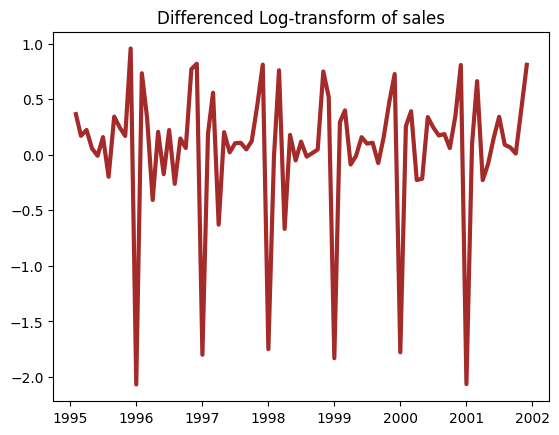

In [6]:
# We try differencing to get rid of the trend
# The trend is gone, but we still have some seasonal
# spikes

# Log transformation
log_sales = np.log(data_ts)

# Differencing
diff_log_sales = log_sales.diff()

# Plotting
plt.plot(diff_log_sales, color='brown', linewidth=3)
plt.title('Differenced Log-transform of sales')
plt.ylabel('')
plt.show()


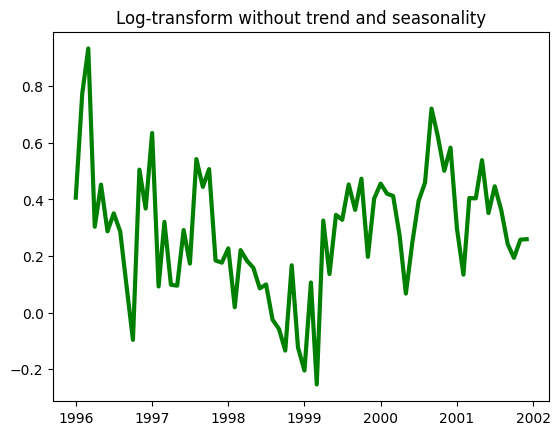

In [7]:
# We could have differenced out the 12 month seasonality first
# on the log scale. But there still seems to be a trend, first going
# down over time then going back up

# Seasonal differencing
diff_log_sales_seasonal = log_sales.diff(periods=12)

# Plotting
plt.plot(diff_log_sales_seasonal, color='green', linewidth=3)
plt.title('Log-transform without trend and seasonality')
plt.ylabel('')
plt.show()



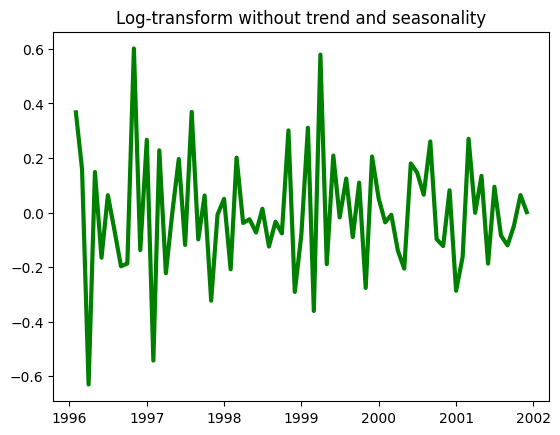

In [8]:
# 12 month seasonal and "normal" differencing of the log data yields something
# that looks more stationary. Maybe the variance at the beginning
# looks different from the variance at the end, but we will just ignore that

# First-order differencing
double_diff = diff_log_sales_seasonal.diff()

# Plotting
plt.plot(double_diff, color='green', linewidth=3)
plt.title('Log-transform without trend and seasonality')
plt.ylabel('')
plt.show()

In [9]:
# TODO: This manual inversion of differencing isn't working right now.

# # Seasonal differencing
# seasonal_diff = log_sales.diff(periods=12)

# # First-order differencing (assumed from previous code)
# final_data = seasonal_diff.diff()

# # Initial values for inverses (assuming first 12 elements)
# xi = seasonal_diff.iloc[:12]  # First 12 elements for seasonal differencing

# # Inverse differencing
# reverse_diff = pd.Series(np.diffinv(final_data.values, xi=xi.values))

# # Inverse seasonal differencing
# reverse_seas_diff = pd.Series(np.diffinv(reverse_diff.values, lag=12, xi=xi.values))

# # Back-transformation
# fully_back_trans = np.exp(reverse_seas_diff.values)

# # Check (assuming original data is in 'suv')
# print(f"Sum of absolute differences between original and back-transformed: {np.sum(np.abs(suv - fully_back_trans))}")

In [51]:
# Note that differencing in python will remove some value from the time series
# and replace them with nan. I.e. 1st order differencing will replace one value
# with nan. Differencing with a frequency of 12 (annual seasonality) will remove
# 12 values, etc

# for i, val in enumerate(diff_log_sales):
# for i, val in enumerate(diff_log_sales_seasonal):
for i, val in enumerate(double_diff):
  if math.isnan(val):
    print(f'index, val: {i}, {val}')
  else:
    print(f'index, val: {i}, {val}')
    break

index, val: 0, nan
index, val: 1, nan
index, val: 2, nan
index, val: 3, nan
index, val: 4, nan
index, val: 5, nan
index, val: 6, nan
index, val: 7, nan
index, val: 8, nan
index, val: 9, nan
index, val: 10, nan
index, val: 11, nan
index, val: 12, nan
index, val: 13, 0.36737733984708054


In [31]:
# ndiffs() is a function that automatically finds the amount of
# of differencing (the integrated term) based on a choice of statistical test
# for stationarity

test = 'adf'  # or use ['kpss', 'adf', 'pp']
alpha = 0.05  # significance level

ts_arrays = [
    log_sales,
    diff_log_sales[1:],
    diff_log_sales_seasonal[12:],
    double_diff[13:]
]

for ts in ts_arrays:
  # Determine the order of differencing
  d = ndiffs(
      ts,
      alpha=alpha,
      test=test)
  print(f"Recommended differencing order: {d}")

Recommended differencing order: 0
Recommended differencing order: 0
Recommended differencing order: 1
Recommended differencing order: 0


In [38]:
# The augmented Dickey-Fuller test, the Phillips–Perron test, and the KPSS Test
# are all hypothesis tests for stationarity. Dickey-Fuller is probably the best
# one. Null hypothesis is that the time series is stationary.

def adfuller_pvalue(data):
  """Calculates the p-value of the Augmented Dickey-Fuller (ADF) test.

  Args:
    data: The time series data to test for stationarity.

  Returns:
    The p-value of the ADF test.
  """
  return adfuller(data)[1]

def kpss_pvalue(data, regression='c'):
  """Performs the KPSS test for level stationarity.

  Args:
    data: The time series data.
    regression: The type of regression for the KPSS test ('c', 'ct', or 'ctt').

  Returns:
    The test results as a tuple.
  """
  return kpss(data, regression=regression, nlags='auto')[1]

def phillips_perron_pvalue(data):
  """Calculates the p-value of the Phillips-Perron test.

  Args:
    data: The time series data to test for stationarity.

  Returns:
    The p-value of the Phillips-Perron test.
  """
  # TODO
  pass

# KPSS seems broken
for ts in ts_arrays:
  p = adfuller_pvalue(ts)
  print(f"ADF pvalue: {p}")
  p = kpss_pvalue(ts)
  print(f"KPSS pvalue: {p}")

ADF pvalue: 0.972631916700852
KPSS pvalue: 0.01
ADF pvalue: 0.038502670535411926
KPSS pvalue: 0.1
ADF pvalue: 0.015009130694441894
KPSS pvalue: 0.1
ADF pvalue: 3.8443606824612165e-06
KPSS pvalue: 0.1


<ipython-input-38-30d38a776c1b>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(data, regression=regression, nlags='auto')[1]
<ipython-input-38-30d38a776c1b>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(data, regression=regression, nlags='auto')[1]
<ipython-input-38-30d38a776c1b>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(data, regression=regression, nlags='auto')[1]
<ipython-input-38-30d38a776c1b>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return

In [49]:
# The null hypothesis of the Ljung-Box test is that there is no autocorrelation
# in the data. If the Ljung-Box test p-value is small, then we believe there is
# autocorrelation in the stationary time series, which suggests ARIMA modeling
# might be fruitful

def box_test(data):
  """Performs the Ljung-Box test for serial correlation.

  Args:
    data: The time series data.

  Returns:
    The test results as a tuple.
  """
  lag = int(np.log(len(data)))
  return sm.stats.diagnostic.acorr_ljungbox(
      data,
      lags=[lag]
      ).lb_pvalue.values[0]

for ts in ts_arrays:
  print(box_test(ts))

1.6454448376777892e-17
0.0008134955510155094
2.3656561668000487e-08
0.00030599688178154774
